# 2400000개 데이터 E:1,922,052, D:349,242, C:127,590 ,A:972, B:144
# A,B에서 오버 샘플링 진행하고 E,D,C 언더 샘플링
# 1000,2000,5000개로 시도

CatBoost돌릴거면 numpy 버전 pip하고 실행

# 데이터로딩

In [ ]:
import pandas as pd
import numpy as np
import gc
import os
from sklearn.preprocessing import LabelEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
train_df=pd.read_csv('/content/drive/MyDrive/신용카드고객/train_df.csv')
test_df=pd.read_csv('/content/drive/MyDrive/신용카드고객/test_df.csv')

Mounted at /content/drive


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
# 원본 데이터프레임에서 20,000개 샘플링 (훈련 데이터)
train_sampled_df = train_df.sample(n=20000, random_state=42)

# 샘플링된 데이터 저장 (훈련 데이터)
train_sampled_df.to_csv('/content/drive/MyDrive/신용카드고객/train_sampled_df.csv', index=False)

# 뽑히지 않은 데이터 추출
train_remaining_df = train_df[~train_df.index.isin(train_sampled_df.index)]

# 남은 데이터에서 검증용 20,000개 샘플링
evaluation_df = train_remaining_df.sample(n=20000, random_state=42)

# 검증용 데이터 저장
evaluation_df.to_csv('/content/drive/MyDrive/신용카드고객/evaluation_df.csv', index=False)

In [ ]:
train_sampled_df=pd.read_csv('/content/drive/MyDrive/신용카드고객/train_sampled_df.csv')
evaluation_df=pd.read_csv('/content/drive/MyDrive/신용카드고객/evaluation_df.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
train_sampled_df=pd.read_csv('/content/drive/MyDrive/신용카드고객/train_sampled_df.csv')
evaluation_df=pd.read_csv('/content/drive/MyDrive/신용카드고객/evaluation_df.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-3-82ab14d2a8ee>:4: DtypeWarning: Columns (385) have mixed types. Specify dtype option on import or set low_memory=False.
  evaluation_df=pd.read_csv('/content/drive/MyDrive/신용카드고객/evaluation_df.csv')


Segment
E    15937
D     2989
C     1063
A       10
B        1
Name: count, dtype: int64


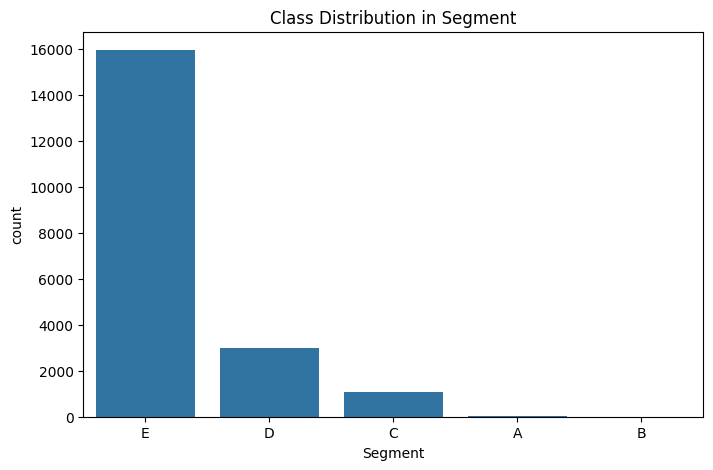

In [ ]:
print(train_sampled_df["Segment"].value_counts())
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(x=train_sampled_df["Segment"])
plt.title("Class Distribution in Segment")
plt.show()


Segment
E    15877
D     3009
C     1103
A       11
Name: count, dtype: int64


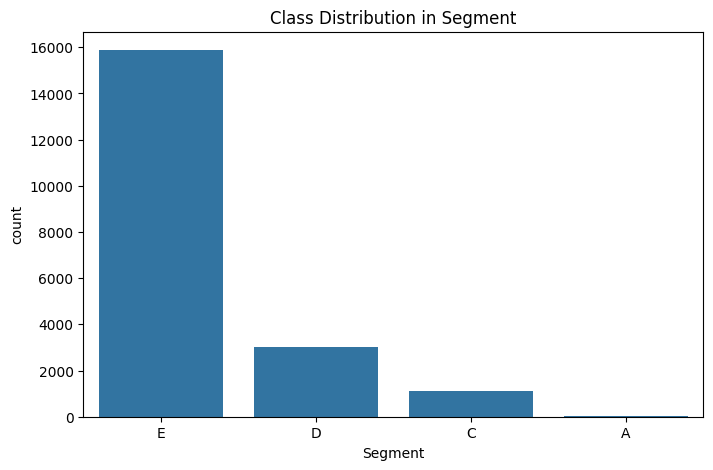

In [ ]:
print(evaluation_df["Segment"].value_counts())
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(x=evaluation_df["Segment"])
plt.title("Class Distribution in Segment")
plt.show()

# 전처리 코드 버전 1

In [ ]:
import numpy as np
import pandas as pd

def preprocess_df(df):
    """
    train_sampled_df와 evaluation_df에 동일한 전처리를 적용하는 함수
    """
    # 1. 업종 목록 결측치 처리
    industry_list = [
        '_3순위여유업종', '_3순위납부업종', '_2순위여유업종', '_3순위교통업종', '_2순위납부업종',
        '_1순위여유업종', '_2순위교통업종', '_3순위쇼핑업종', '_1순위납부업종', '_1순위교통업종',
        '_2순위쇼핑업종', '_3순위업종', '_1순위쇼핑업종', '_2순위업종', '_1순위업종'
    ]
    for industry in industry_list:
        if industry in df.columns:
            df[industry] = df[industry].fillna('없음')

    # 2. 불필요한 열 삭제
    columns_to_drop = [
        '연체일자_B0M', '최종카드론_대출일자', '최종카드론_신청경로코드', '최종카드론_금융상환방식코드',
        'RV신청일자', 'OS구분코드'
    ]
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

    # 3. 가입통신회사코드 처리
    if '회원여부_이용가능' in df.columns and '이용금액_R3M_신용' in df.columns:
        df['가입통신회사코드'] = np.where(
            (df['회원여부_이용가능'] == 'N') | (df['이용금액_R3M_신용'] == 0),
            '미가입',
            df['가입통신회사코드'].fillna('Unknown')
        )

    # 4. 직장시도명 처리
    if '거주시도명' in df.columns:
        df['직장시도명'] = np.where(
            df['직장시도명'].isna() & df['거주시도명'].notna(),
            df['거주시도명'],
            df['직장시도명'].fillna('Unknown')
        )

    # 5. RV전환가능여부 처리
    if '소지여부_신용' in df.columns and '이용금액_R3M_신용' in df.columns:
        df['RV전환가능여부'] = np.where(
            (df['이용금액_R3M_신용'] == 0) | (df['소지여부_신용'] == 'N'),
            'N',
            df['RV전환가능여부'].fillna('Unknown')
        )

    # 6. _1순위신용체크구분 처리
    if '_1순위업종' in df.columns and '이용금액_R3M_신용' in df.columns:
        df['_1순위신용체크구분'] = np.where(
            df['이용금액_R3M_신용'] == 0,
            '미사용',
            np.where(
                df['_1순위신용체크구분'].isna() & df['_1순위업종'].notna() & (df['_1순위업종'] != '없음'),
                '신용',
                df['_1순위신용체크구분'].fillna('미사용')
            )
        )
        # _1순위와 _2순위 상호작용
        df.loc[df['_1순위신용체크구분'] == '신용', '_2순위신용체크구분'] = '체크'
        df.loc[df['_1순위신용체크구분'] == '체크', '_2순위신용체크구분'] = '신용'
        df.loc[df['_1순위신용체크구분'] == '미사용', '_2순위신용체크구분'] = '미사용'

    # 7. 혜택수혜율 처리
    if '혜택수혜율_R3M' in df.columns:
        df['혜택수혜율_B0M'] = np.where(
            df['혜택수혜율_B0M'].isna() & df['혜택수혜율_R3M'].notna(),
            df['혜택수혜율_R3M'],
            df['혜택수혜율_B0M']
        )
        df['혜택수혜율_B0M'] = df['혜택수혜율_B0M'].fillna(0)

        df['혜택수혜율_R3M'] = np.where(
            df['혜택수혜율_R3M'].isna() & df['혜택수혜율_B0M'].notna(),
            df['혜택수혜율_B0M'],
            df['혜택수혜율_R3M']
        )
        df['혜택수혜율_R3M'] = df['혜택수혜율_R3M'].fillna(0)

        # 도메인 반영
        if '소지여부_신용' in df.columns:
            df.loc[(df['소지여부_신용'] == 'N') | (df['이용금액_R3M_신용'] == 0), ['혜택수혜율_B0M', '혜택수혜율_R3M']] = 0

    # 8. 날짜 열 결측치 처리
    date_cols = ['최종유효년월_신용_이용', '최종유효년월_신용_이용가능', '최종카드발급일자']
    for col in date_cols:
        if col in df.columns:
            df[col] = df[col].fillna(-1)

    return df

# 전처리 적용
train_sampled_df = preprocess_df(train_sampled_df)
evaluation_df = preprocess_df(evaluation_df)

# 결과 확인 (선택적)
print("train_sampled_df after preprocessing:")
print(train_sampled_df.head())
print("evaluation_df after preprocessing:")
print(evaluation_df.head())

train_sampled_df after preprocessing:
   Unnamed: 0    기준년월            ID  남녀구분코드   연령 Segment  회원여부_이용가능  \
0      599866  201808  TRAIN_199866       2  30대       E          1   
1      427635  201808  TRAIN_027635       1  50대       E          0   
2     1833852  201811  TRAIN_233852       2  40대       E          1   
3      690821  201808  TRAIN_290821       1  40대       E          1   
4     1098632  201809  TRAIN_298632       2  30대       D          1   

   회원여부_이용가능_CA  회원여부_이용가능_카드론  소지여부_신용  ...  변동률_RV일시불평잔  변동률_할부평잔  변동률_CA평잔  \
0             1              0        1  ...     0.999998  1.987409  0.999998   
1             0              0        1  ...     0.999998  0.999998  0.999998   
2             1              1        1  ...     0.999998  0.999998  0.999998   
3             1              1        1  ...     0.999998  0.904525  0.999998   
4             1              1        1  ...     0.952195  0.604032  0.999998   

   변동률_RVCA평잔  변동률_카드론평잔  변동률_잔액_B1M  변동률_잔액_일시불

# 전처리 코드 버전2

In [ ]:
# 전처리시, 혜택수혜율 결측치 예측 및 대체를 위한 함수 작성 코드

import pandas as pdf
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import LabelEncoder

def predict_and_fill_missing_targets(
    df: pd.DataFrame,
    features: list,
    targets: list,
    sample_size: int = None,
    model=None,
    random_state: int = 42
    ):
    """
    멀티타겟 회귀를 이용해 결측값을 예측하고 원본 데이터프레임에 채워 넣는 함수

    Parameters:
    - df: 입력 데이터프레임
    - features: 예측에 사용할 feature 컬럼 리스트
    - targets: 결측치를 대체할 target 컬럼 리스트
    - sample_size: 학습 및 예측에 사용할 샘플 수 (None이면 전체 사용)
    - model: 사용할 회귀 모델 (None이면 RandomForest 기본 모델 사용)
    - random_state: 샘플링 및 모델 재현성을 위한 시드값

    Returns:
    - df: 결측치가 대체된 새로운 데이터프레임
    - before_preds: 결측치 이전의 원본 (NaN) 값들
    - after_preds: 예측된 값들
    """

    df = df.copy()

    # 범주형 컬럼 인코딩
    for col in features:
        if df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))

    # 학습/예측 데이터 분리
    train = df[df[targets].notnull().all(axis=1)]
    test = df[df[targets].isnull().any(axis=1)]

    X_train, y_train = train[features], train[targets]
    X_test = test[features]

    # 기본 모델 설정
    if model is None:
        model = MultiOutputRegressor(RandomForestRegressor(n_estimators=50, random_state=random_state))

    # 학습 및 예측
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)

    # 결과 반영
    df.loc[test.index, targets] = predicted

    # 예측 전/후 값 반환
    before_preds = test[targets]
    after_preds = pd.DataFrame(predicted, index=test.index, columns=targets)

    return df, before_preds, after_preds

In [ ]:
# 전처리 함수 - 1

def preprocess_df(df):

    # STEP_1 : 동일 값 컬럼 제거 (컬럼 내에 데이터가 모두 동일값이어서 분류모델에서 의미가 없음)

    # 동일한 값만 있는 컬럼 리스트
    # constant_cols 이중 리스트 → 평탄화
    constant_cols = ['이용카드수_체크_가족', '이용금액_R3M_체크_가족', '연회비할인카드수_B0M', '할인금액_기본연회비_B0M', '할인금액_제휴연회비_B0M',
                    '상품관련면제카드수_B0M', '임직원면제카드수_B0M', '우수회원면제카드수_B0M', '기타면제카드수_B0M', '시장연체상환여부_R3M',
                    '이용건수_부분무이자_B0M', '이용금액_부분무이자_B0M', '여유_여행이용금액', '납부_렌탈료이용금액', '납부_유선방송이용금액',
                    '납부_건강연금이용금액', '할부건수_부분_3M_R12M', '할부건수_부분_6M_R12M', '할부건수_부분_14M_R12M', '할부금액_부분_3M_R12M',
                    'RP건수_유선방송_B0M', 'RP건수_건강_B0M', 'RP후경과월_유선방송', 'RP후경과월_건강', '증감_RP건수_유선방송_전월', '증감_RP건수_건강_전월',
                    '이용개월수_당사페이_R6M', '이용금액_당사페이_R6M', '이용금액_당사기타_R6M', '이용건수_당사페이_R6M', '이용건수_당사기타_R6M',
                    '이용금액_당사페이_R3M', '이용금액_당사기타_R3M', '이용건수_당사페이_R3M', '이용건수_당사기타_R3M', '이용금액_당사페이_B0M', '이용금액_당사기타_B0M',
                    '이용건수_당사페이_B0M', '이용건수_당사기타_B0M', '승인거절건수_입력오류_B0M', '승인거절건수_기타_B0M', '대표결제방법코드', '카드론잔액_최종경과월',
                    '최종연체개월수_R15M', 'RV잔액이월횟수_R6M', 'RV잔액이월횟수_R3M', '연체잔액_일시불_해외_B0M', '연체잔액_RV일시불_해외_B0M', '연체잔액_할부_해외_B0M',
                    '연체잔액_CA_해외_B0M', '인입횟수_금융_IB_R6M', '인입불만횟수_IB_R6M', '인입불만일수_IB_R6M', '인입불만월수_IB_R6M', '인입불만후경과월_IB_R6M',
                    '인입불만횟수_IB_B0M', '인입불만일수_IB_B0M', 'IB문의건수_한도_B0M', 'IB문의건수_결제_B0M', 'IB문의건수_할부_B0M', 'IB문의건수_정보변경_B0M',
                    'IB문의건수_결제일변경_B0M', 'IB문의건수_명세서_B0M', 'IB문의건수_비밀번호_B0M', 'IB문의건수_SMS_B0M', 'IB문의건수_APP_B0M', 'IB문의건수_부대서비스_B0M',
                    'IB문의건수_포인트_B0M', 'IB문의건수_BL_B0M', 'IB문의건수_분실도난_B0M', 'IB문의건수_CA_B0M', 'IB상담건수_VOC_B0M', 'IB상담건수_VOC민원_B0M',
                    'IB상담건수_VOC불만_B0M', 'IB상담건수_금감원_B0M', 'IB문의건수_명세서_R6M', 'IB문의건수_APP_R6M', 'IB상담건수_VOC_R6M', 'IB상담건수_VOC민원_R6M',
                    'IB상담건수_VOC불만_R6M', 'IB상담건수_금감원_R6M', '불만제기건수_B0M', '불만제기건수_R12M', '당사PAY_방문횟수_B0M', '당사PAY_방문횟수_R6M',
                    '당사PAY_방문월수_R6M', '컨택건수_CA_TM_B0M', '컨택건수_포인트소진_TM_B0M', '컨택건수_CA_EM_B0M', '컨택건수_리볼빙_EM_B0M', '컨택건수_리볼빙_청구서_B0M',
                    '컨택건수_카드론_인터넷_B0M', '컨택건수_CA_인터넷_B0M', '컨택건수_리볼빙_인터넷_B0M', '컨택건수_카드론_당사앱_B0M', '컨택건수_CA_당사앱_B0M',
                    '컨택건수_리볼빙_당사앱_B0M', '컨택건수_CA_EM_R6M', '컨택건수_리볼빙_EM_R6M', '컨택건수_리볼빙_청구서_R6M', '컨택건수_카드론_인터넷_R6M',
                    '컨택건수_CA_인터넷_R6M', '컨택건수_리볼빙_인터넷_R6M', '컨택건수_카드론_당사앱_R6M', '컨택건수_CA_당사앱_R6M', '컨택건수_리볼빙_당사앱_R6M',
                    '컨택건수_FDS_B0M', '컨택건수_FDS_R6M']

    # 결과 출력
    print(f"동일한 값만 있는 컬럼 개수: {len(constant_cols)}")
    print("컬럼 이름 목록:", constant_cols)

    # 해당 컬럼 삭제
    df = df.drop(columns=constant_cols)


    print('------------------------------------<STEP_1 완료>------------------------------------')

    # STEP_2 : 결측치 확인

    # 3) 업종 목록 결측치 'Unknown' 처리 (➡️ 나중에 디벨롭 필요)
    industry_list = [
        '_3순위여유업종', '_3순위납부업종', '_2순위여유업종', '_3순위교통업종', '_2순위납부업종',
        '_1순위여유업종', '_2순위교통업종', '_3순위쇼핑업종', '_1순위납부업종', '_1순위교통업종',
        '_2순위쇼핑업종', '_3순위업종', '_1순위쇼핑업종', '_2순위업종', '_1순위업종'
    ]
    for industry in industry_list:
        if industry in df.columns:
            df[industry] = df[industry].fillna('없음')

    # STEP_3 : 결측치 제거 및 대체

    # 1) 결측률 80% 이상인 컬럼 제거

    columns_to_drop = [
        '연체일자_B0M', '최종카드론_대출일자', '최종카드론_신청경로코드', '최종카드론_금융상환방식코드',
        'RV신청일자', 'OS구분코드'
    ]
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

    # 2) 기존 컬럼과 동일한 값을 포함하는 결측치 컬럼 제거 (직장도시명)
    df = df.drop(columns=["직장도시명"], errors='ignore')

    # 4) 가입통신회사코드 결측치 처리
    if '가입통신회사코드' in df.columns :
        df['가입통신회사코드'] = np.where(
            (df['회원여부_이용가능'] == 'N') | (df['이용금액_R3M_신용'] == 0),
            '미가입',
            df['가입통신회사코드'].fillna('Unknown')
        )

    # 5) 1순위신용체크구분, 2순위신용체크구분 'Unknown' 처리 (➡️ 나중에 디벨롭 필요)
    df.loc[df['_1순위신용체크구분'] == '신용', '_2순위신용체크구분'] = '체크'
    df.loc[df['_1순위신용체크구분'] == '체크', '_2순위신용체크구분'] = '신용'
    df.loc[df['_1순위신용체크구분'] == '미사용', '_2순위신용체크구분'] = '미사용'


    # 6) OS구분코드 'Unknown' 처리 (➡️ 나중에 디벨롭 필요)
    columns_list = [ "OS구분코드"]
    for industry in columns_list:
        if industry in df.columns:
            df[industry] = df[industry].fillna('Unknown')


    # 7) 혜택수혜율_R3M, 혜택수혜율_B0M 결측치 예측 및 대체 -> 멀티타겟, 다중선형회귀분석
    features = [
    '이용금액_R3M_신용', '이용금액_R3M_체크',
    '소지카드수_유효_신용', '유효카드수_체크',
    '증감율_이용건수_일시불_전월', '이용건수_신판_R3M',
    '연령', '남녀구분코드'
    ]

    targets = ['혜택수혜율_R3M', '혜택수혜율_B0M']

    df, before_preds, after_preds = predict_and_fill_missing_targets(
        df= df,
        features= features,
        targets= targets,
        sample_size= 2000000
        )

    # 8) 최종카드발급일자 -> 결측치는 -1처리
    df["최종카드발급일자"] = df["최종카드발급일자"].fillna(-1)

    # 9) 최종유효년월_신용_이용, 최종유효년월_신용_이용가능 -> 최종 카드발급일자에 500(5년) 더하기
    df["최종유효년월_신용_이용"] = df["최종유효년월_신용_이용"].fillna(-1)
    df["최종유효년월_신용_이용가능"] = df["최종유효년월_신용_이용가능"].fillna(-1)

    '''columns_list = ["최종유효년월_신용_이용", "최종유효년월_신용_이용가능"]
    for industry in columns_list:
        if industry in df.columns:
            if df["최종카드발급일자"] == -1 :
                df[industry] = df[industry].fillna(-1)
            else :
                df[industry] = df[industry].fillna(500 + df['최종카드발급일자'].astype(str).str[:6].astype(int))'''

    # 10) RV전환가능여부 -> 결측치 얼마 없어서 일단 Unknown 처리
    columns_list = ["RV전환가능여부"]
    for industry in columns_list:
        if industry in df.columns:
            df[industry] = df[industry].fillna('Unknown')

    print('------------------------------------<STEP_3 완료>------------------------------------')

    return df

train_sampled_df = preprocess_df(train_sampled_df)
evaluation_df = preprocess_df(evaluation_df)


동일한 값만 있는 컬럼 개수: 108
컬럼 이름 목록: ['이용카드수_체크_가족', '이용금액_R3M_체크_가족', '연회비할인카드수_B0M', '할인금액_기본연회비_B0M', '할인금액_제휴연회비_B0M', '상품관련면제카드수_B0M', '임직원면제카드수_B0M', '우수회원면제카드수_B0M', '기타면제카드수_B0M', '시장연체상환여부_R3M', '이용건수_부분무이자_B0M', '이용금액_부분무이자_B0M', '여유_여행이용금액', '납부_렌탈료이용금액', '납부_유선방송이용금액', '납부_건강연금이용금액', '할부건수_부분_3M_R12M', '할부건수_부분_6M_R12M', '할부건수_부분_14M_R12M', '할부금액_부분_3M_R12M', 'RP건수_유선방송_B0M', 'RP건수_건강_B0M', 'RP후경과월_유선방송', 'RP후경과월_건강', '증감_RP건수_유선방송_전월', '증감_RP건수_건강_전월', '이용개월수_당사페이_R6M', '이용금액_당사페이_R6M', '이용금액_당사기타_R6M', '이용건수_당사페이_R6M', '이용건수_당사기타_R6M', '이용금액_당사페이_R3M', '이용금액_당사기타_R3M', '이용건수_당사페이_R3M', '이용건수_당사기타_R3M', '이용금액_당사페이_B0M', '이용금액_당사기타_B0M', '이용건수_당사페이_B0M', '이용건수_당사기타_B0M', '승인거절건수_입력오류_B0M', '승인거절건수_기타_B0M', '대표결제방법코드', '카드론잔액_최종경과월', '최종연체개월수_R15M', 'RV잔액이월횟수_R6M', 'RV잔액이월횟수_R3M', '연체잔액_일시불_해외_B0M', '연체잔액_RV일시불_해외_B0M', '연체잔액_할부_해외_B0M', '연체잔액_CA_해외_B0M', '인입횟수_금융_IB_R6M', '인입불만횟수_IB_R6M', '인입불만일수_IB_R6M', '인입불만월수_IB_R6M', '인입불만후경과월_IB_R6M', '인입불만횟수_IB_B0M', '인입불만일수_IB_B0M', 'IB문의

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
import numpy as np
import pandas as pd
import gc

# 데이터 준비
feature_cols = [col for col in train_sampled_df.columns if col not in ["ID", "Segment"]]
X = train_sampled_df[feature_cols].copy()
y = train_sampled_df["Segment"].copy()

# 타깃 라벨 인코딩
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

# 범주형 피처 정의 및 인코딩
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
X_test = evaluation_df.copy()
y_true = X_test["Segment"].copy()
y_true_encoded = le_target.transform(y_true)
X_test = X_test[feature_cols]

encoders = {}
for col in categorical_features:
    le_train = LabelEncoder()
    X[col] = le_train.fit_transform(X[col])
    encoders[col] = le_train
    X_test[col] = X_test[col].fillna('missing').astype(str)
    unseen_labels_val = set(X_test[col]) - set(le_train.classes_)
    if unseen_labels_val:
        le_train.classes_ = np.append(le_train.classes_, list(unseen_labels_val))
    X_test[col] = le_train.transform(X_test[col])

gc.collect()

# CatBoost 모델 학습 및 평가
catboost_model = CatBoostClassifier(verbose=0, random_state=42)
catboost_model.fit(X, y_encoded)
y_pred_train = catboost_model.predict(X)
f1_train = f1_score(y_encoded, y_pred_train, average='weighted')

y_pred = catboost_model.predict(X_test)
f1_test = f1_score(y_true_encoded, y_pred, average='weighted')

print(f"CatBoost - Train F1: {f1_train:.4f}, Test F1: {f1_test:.4f}")


<ipython-input-4-81b66571c801>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].fillna('missing').astype(str)
<ipython-input-4-81b66571c801>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = le_train.transform(X_test[col])
<ipython-input-4-81b66571c801>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

CatBoost - Train F1: 0.9637, Test F1: 0.8893


# TabNet(Jupyter에서 돌림)

In [ ]:
pip install rtdl -q

In [ ]:
# 1. 기존 PyTorch 제거
!pip uninstall -y torch torchvision torchaudio
!pip cache purge

# 2. 안정적인 버전으로 재설치 (CUDA 11.8 지원)
!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 --index-url https://download.pytorch.org/whl/cu118


In [ ]:
# 필수 라이브러리
import numpy as np
import pandas as pd
import torch
import os
import random
import gc

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from pytorch_tabnet.tab_model import TabNetClassifier

# 시드 고정 함수
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

# 데이터셋 준비
feature_cols = [col for col in train_sampled_df.columns if col not in ["ID", "Segment"]]
X = train_sampled_df[feature_cols].copy()
y = train_sampled_df["Segment"].copy()

le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

X_test = evaluation_df[feature_cols].copy()
y_true = evaluation_df["Segment"].copy()
y_true_encoded = le_target.transform(y_true)

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    X_test[col] = X_test[col].fillna('missing').astype(str)
    unseen = set(X_test[col]) - set(le.classes_)
    if unseen:
        le.classes_ = np.append(le.classes_, list(unseen))
    X_test[col] = le.transform(X_test[col])
    encoders[col] = le

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)


# TabNet 학습 및 평가
try:
    print("Training TabNet...")
    clf_tabnet = TabNetClassifier(seed=42)
    clf_tabnet.fit(
        X.values, y_encoded,
        eval_set=[(X_test.values, y_true_encoded)],
        eval_name=['test'],
        eval_metric=['accuracy'],
        max_epochs=100,
        patience=10,
        batch_size=1024,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False
    )

    y_pred_train_tabnet = clf_tabnet.predict(X.values)
    y_pred_tabnet = clf_tabnet.predict(X_test.values)

    f1_train_tabnet = f1_score(y_encoded, y_pred_train_tabnet, average='weighted')
    f1_test_tabnet = f1_score(y_true_encoded, y_pred_tabnet, average='weighted')
    print(f"TabNet - Train F1: {f1_train_tabnet:.4f}, Test F1: {f1_test_tabnet:.4f}")
except Exception as e:
    print(f"TabNet failed: {e}")


Training TabNet...
C:\Users\user\anaconda3\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
epoch 0  | loss: 0.93222 | test_accuracy: 0.77705 |  0:00:23s
epoch 1  | loss: 0.57087 | test_accuracy: 0.42175 |  0:00:50s
epoch 2  | loss: 0.51032 | test_accuracy: 0.76045 |  0:01:04s
epoch 3  | loss: 0.46622 | test_accuracy: 0.7983  |  0:01:18s
epoch 4  | loss: 0.4302  | test_accuracy: 0.77005 |  0:01:32s
epoch 5  | loss: 0.42396 | test_accuracy: 0.80905 |  0:01:51s
epoch 6  | loss: 0.40947 | test_accuracy: 0.8293  |  0:02:05s
epoch 7  | loss: 0.39964 | test_accuracy: 0.8361  |  0:02:19s
epoch 8  | loss: 0.39249 | test_accuracy: 0.8378  |  0:02:32s
epoch 9  | loss: 0.39234 | test_accuracy: 0.84085 |  0:02:46s
epoch 10 | loss: 0.39019 | test_accuracy: 0.83985 |  0:03:01s
epoch 11 | loss: 0.38356 | test_accuracy: 0.8408  |  0:03:15s
epoch 12 | loss: 0.3766  | test_accuracy: 0.8423  |  0:03:30s
epoch 13 | loss: 0.37444 | test_accuracy: 0.8405  |  0:03:43s
epoch 14 | loss: 0.37173 | test_accuracy: 0.83625 |  0:03:59s
epoch 15 | loss: 0.36827 | test_accuracy: 0.84145 |  0:04:14s
epoch 16 | loss: 0.36452 | test_accuracy: 0.8391  |  0:04:31s
epoch 17 | loss: 0.36625 | test_accuracy: 0.84135 |  0:04:46s
epoch 18 | loss: 0.368   | test_accuracy: 0.84465 |  0:05:01s
epoch 19 | loss: 0.36425 | test_accuracy: 0.84205 |  0:05:16s
epoch 20 | loss: 0.3624  | test_accuracy: 0.84095 |  0:05:31s
epoch 21 | loss: 0.35924 | test_accuracy: 0.84445 |  0:05:47s
epoch 22 | loss: 0.35612 | test_accuracy: 0.84295 |  0:06:03s
epoch 23 | loss: 0.35343 | test_accuracy: 0.8419  |  0:06:19s
epoch 24 | loss: 0.3504  | test_accuracy: 0.83785 |  0:06:33s
epoch 25 | loss: 0.34639 | test_accuracy: 0.8404  |  0:06:49s
epoch 26 | loss: 0.34824 | test_accuracy: 0.82205 |  0:07:06s
epoch 27 | loss: 0.34763 | test_accuracy: 0.84285 |  0:07:22s
epoch 28 | loss: 0.34708 | test_accuracy: 0.8409  |  0:07:37s

Early stopping occurred at epoch 28 with best_epoch = 18 and best_test_accuracy = 0.84465
C:\Users\user\anaconda3\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
TabNet - Train F1: 0.8345, Test F1: 0.8285


#FT Transformer 미니배치X

In [ ]:
# 필수 라이브러리
import numpy as np
import pandas as pd
import torch
import os
import random
import gc

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import rtdl  # FT Transformer 라이브러리
import torch.nn as nn

# 시드 고정 함수
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

# 데이터셋 준비
feature_cols = [col for col in train_sampled_df.columns if col not in ["ID", "Segment"]]  # 피처 열 선택
X = train_sampled_df[feature_cols].copy()  # 훈련 데이터 복사
y = train_sampled_df["Segment"].copy()  # 타겟 데이터 복사

X_test = evaluation_df[feature_cols].copy()  # 테스트 데이터 복사
y_true = evaluation_df["Segment"].copy()  # 테스트 타겟 복사

# 타겟 인코딩 (타겟은 여전히 숫자로 변환 필요)
from sklearn.preprocessing import LabelEncoder
le_target = LabelEncoder()  # 타겟 라벨 인코더
y_encoded = le_target.fit_transform(y)  # 훈련 타겟 인코딩
y_true_encoded = le_target.transform(y_true)  # 테스트 타겟 인코딩

# 범주형 및 수치형 피처 분리
categorical_features = X.select_dtypes(include=['object']).columns.tolist()  # 범주형 피처 목록
numerical_features = [col for col in feature_cols if col not in categorical_features]  # 수치형 피처 목록

# 수치형 피처 스케일링
scaler = StandardScaler()  # 표준화 스케일러
X_num = scaler.fit_transform(X[numerical_features])  # 훈련 데이터 수치형 피처 스케일링
X_test_num = scaler.transform(X_test[numerical_features])  # 테스트 데이터 수치형 피처 스케일링

# 범주형 피처의 카디널리티 계산
cat_cardinalities = [len(X[col].unique()) for col in categorical_features]  # 각 범주형 피처의 고유 값 개수

# 범주형 피처를 정수형으로 변환 (0부터 시작하는 인덱스로)
X_cat = np.stack([X[col].astype('category').cat.codes for col in categorical_features], axis=1)  # 훈련 데이터 범주형 변환
X_test_cat = np.stack([X_test[col].fillna('missing').astype('category').cat.codes for col in categorical_features], axis=1)  # 테스트 데이터 범주형 변환

# FT Transformer용 데이터 준비 (torch 텐서로 변환)
X_num_tensor = torch.tensor(X_num, dtype=torch.float32)  # 훈련 수치형 데이터 텐서
X_cat_tensor = torch.tensor(X_cat, dtype=torch.long) if categorical_features else None  # 훈련 범주형 데이터 텐서 (없으면 None)
y_encoded_tensor = torch.tensor(y_encoded, dtype=torch.long)  # 훈련 타겟 텐서
X_test_num_tensor = torch.tensor(X_test_num, dtype=torch.float32)  # 테스트 수치형 데이터 텐서
X_test_cat_tensor = torch.tensor(X_test_cat, dtype=torch.long) if categorical_features else None  # 테스트 범주형 데이터 텐서
y_true_encoded_tensor = torch.tensor(y_true_encoded, dtype=torch.long)  # 테스트 타겟 텐서


# FT Transformer 학습 및 평가
try:
    print("FT Transformer 학습 시작...")

    # FT Transformer 모델 정의
    d_out = 64  # FT Transformer 출력 차원 (임의로 64로 설정, 조정 가능)
    ft_transformer = rtdl.FTTransformer.make_default(
        n_num_features=len(numerical_features),  # 수치형 피처 수
        cat_cardinalities=cat_cardinalities if categorical_features else None,  # 범주형 피처 카디널리티
        d_out=d_out  # 출력 차원 명시
    )

    # 분류를 위한 출력 레이어 정의
    n_classes = len(np.unique(y_encoded))  # 클래스 수
    classifier = nn.Linear(d_out, n_classes)  # 출력 레이어

    # 옵티마이저와 손실 함수 정의
    optimizer = torch.optim.Adam(list(ft_transformer.parameters()) + list(classifier.parameters()), lr=1e-3)  # Adam 옵티마이저
    loss_fn = nn.CrossEntropyLoss()  # 교차 엔트로피 손실 함수

    # 장치 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU 사용 여부 확인
    ft_transformer.to(device)  # FT Transformer를 장치로 이동
    classifier.to(device)  # 출력 레이어를 장치로 이동
    X_num_tensor = X_num_tensor.to(device)  # 훈련 수치형 데이터 장치로 이동
    X_cat_tensor = X_cat_tensor.to(device) if X_cat_tensor is not None else None  # 훈련 범주형 데이터 장치로 이동
    y_encoded_tensor = y_encoded_tensor.to(device)  # 훈련 타겟 장치로 이동
    X_test_num_tensor = X_test_num_tensor.to(device)  # 테스트 수치형 데이터 장치로 이동
    X_test_cat_tensor = X_test_cat_tensor.to(device) if X_test_cat_tensor is not None else None  # 테스트 범주형 데이터 장치로 이동
    y_true_encoded_tensor = y_true_encoded_tensor.to(device)  # 테스트 타겟 장치로 이동

    # 학습 루프
    max_epochs = 100  # 최대 에포크 수
    patience = 10  # 조기 종료 인내심
    best_f1 = -float('inf')  # 최고 F1 점수 초기화
    patience_counter = 0  # 조기 종료 카운터

    for epoch in range(max_epochs):
        ft_transformer.train()  # 학습 모드
        classifier.train()
        optimizer.zero_grad()  # 기울기 초기화
        transformer_output = ft_transformer(X_num_tensor, X_cat_tensor)  # FT Transformer 출력
        outputs = classifier(transformer_output)  # 출력 레이어로 클래스 예측
        loss = loss_fn(outputs, y_encoded_tensor)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트

        # 평가
        ft_transformer.eval()  # 평가 모드
        classifier.eval()
        with torch.no_grad():  # 기울기 계산 비활성화
            test_transformer_output = ft_transformer(X_test_num_tensor, X_test_cat_tensor)  # 테스트 데이터로 FT Transformer 출력
            y_pred_test = classifier(test_transformer_output).argmax(dim=1).cpu().numpy()  # 테스트 예측
            f1_test = f1_score(y_true_encoded, y_pred_test, average='weighted')  # 테스트 F1 점수
            print(f"에포크 {epoch+1}/{max_epochs}, 테스트 F1: {f1_test:.4f}")

            # 조기 종료
            if f1_test > best_f1:
                best_f1 = f1_test  # 최고 F1 점수 갱신
                patience_counter = 0  # 카운터 초기화
            else:
                patience_counter += 1  # 카운터 증가
                if patience_counter >= patience:
                    print("조기 종료가 실행되었습니다.")
                    break

    # 최종 예측
    ft_transformer.eval()  # 평가 모드
    classifier.eval()
    with torch.no_grad():
        train_transformer_output = ft_transformer(X_num_tensor, X_cat_tensor)
        y_pred_train_ft = classifier(train_transformer_output).argmax(dim=1).cpu().numpy()  # 훈련 데이터 예측
        test_transformer_output = ft_transformer(X_test_num_tensor, X_test_cat_tensor)
        y_pred_test_ft = classifier(test_transformer_output).argmax(dim=1).cpu().numpy()  # 테스트 데이터 예측

    f1_train_ft = f1_score(y_encoded, y_pred_train_ft, average='weighted')  # 훈련 F1 점수
    f1_test_ft = f1_score(y_true_encoded, y_pred_test_ft, average='weighted')  # 테스트 F1 점수
    print(f"FT Transformer - 훈련 F1: {f1_train_ft:.4f}, 테스트 F1: {f1_test_ft:.4f}")

except Exception as e:
    print(f"FT Transformer 실패: {e}")

FT Transformer 학습 시작...


#미니배치

In [ ]:
import numpy as np
import pandas as pd
import torch
import os
import random
import gc

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import rtdl

# 시드 고정
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

# 데이터 전처리
feature_cols = [col for col in train_sampled_df.columns if col not in ["ID", "Segment"]]
X = train_sampled_df[feature_cols].copy()
y = train_sampled_df["Segment"].copy()
X_test = evaluation_df[feature_cols].copy()
y_true = evaluation_df["Segment"].copy()

le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)
y_true_encoded = le_target.transform(y_true)

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = [col for col in feature_cols if col not in categorical_features]

scaler = StandardScaler()
X_num = scaler.fit_transform(X[numerical_features])
X_test_num = scaler.transform(X_test[numerical_features])

cat_cardinalities = [len(X[col].unique()) for col in categorical_features]

X_cat = np.stack([X[col].astype('category').cat.codes for col in categorical_features], axis=1) if categorical_features else None
X_test_cat = np.stack([X_test[col].fillna('missing').astype('category').cat.codes for col in categorical_features], axis=1) if categorical_features else None

# torch 텐서 변환
X_num_tensor = torch.tensor(X_num, dtype=torch.float32)
X_cat_tensor = torch.tensor(X_cat, dtype=torch.long) if categorical_features else None
y_encoded_tensor = torch.tensor(y_encoded, dtype=torch.long)

X_test_num_tensor = torch.tensor(X_test_num, dtype=torch.float32)
X_test_cat_tensor = torch.tensor(X_test_cat, dtype=torch.long) if categorical_features else None
y_true_encoded_tensor = torch.tensor(y_true_encoded, dtype=torch.long)

# Dataloader 준비
train_dataset = TensorDataset(X_num_tensor, X_cat_tensor, y_encoded_tensor)
test_dataset = TensorDataset(X_test_num_tensor, X_test_cat_tensor, y_true_encoded_tensor)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 모델 정의
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

d_out = 64
n_classes = len(np.unique(y_encoded))

ft_transformer = rtdl.FTTransformer.make_default(
    n_num_features=len(numerical_features),
    cat_cardinalities=cat_cardinalities if categorical_features else None,
    d_out=d_out,
)
classifier = nn.Linear(d_out, n_classes)

ft_transformer.to(device)
classifier.to(device)

# 옵티마이저, 손실함수
optimizer = torch.optim.Adam(
    list(ft_transformer.parameters()) + list(classifier.parameters()), lr=1e-3
)
loss_fn = nn.CrossEntropyLoss()

# 학습 루프 (with 배치)
max_epochs = 100
patience = 10
best_f1 = -float("inf")
patience_counter = 0

for epoch in range(max_epochs):
    ft_transformer.train()
    classifier.train()
    total_loss = 0

    for X_num_batch, X_cat_batch, y_batch in train_loader:
        X_num_batch = X_num_batch.to(device)
        X_cat_batch = X_cat_batch.to(device) if X_cat_batch is not None else None
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        output = ft_transformer(X_num_batch, X_cat_batch)
        preds = classifier(output)
        loss = loss_fn(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # 평가
    ft_transformer.eval()
    classifier.eval()
    y_pred_test = []

    with torch.no_grad():
        for X_num_batch, X_cat_batch, _ in test_loader:
            X_num_batch = X_num_batch.to(device)
            X_cat_batch = X_cat_batch.to(device) if X_cat_batch is not None else None
            logits = classifier(ft_transformer(X_num_batch, X_cat_batch))
            preds = torch.argmax(logits, dim=1)
            y_pred_test.extend(preds.cpu().numpy())

    f1_test = f1_score(y_true_encoded, y_pred_test, average='weighted')
    print(f"[{epoch+1:03d}] 테스트 F1: {f1_test:.4f}")

    # 조기 종료 체크
    if f1_test > best_f1:
        best_f1 = f1_test
        patience_counter = 0
        best_model = {
            "ft": ft_transformer.state_dict(),
            "clf": classifier.state_dict()
        }
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("조기 종료 triggered.")
            break

# 최종 평가
print(f"최종 테스트 F1 점수: {best_f1:.4f}")


# 미내배치+경량화

In [ ]:
import numpy as np
import pandas as pd
import torch
import os
import random
import gc

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import rtdl

# 시드 고정
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

# 데이터 전처리
feature_cols = [col for col in train_sampled_df.columns if col not in ["ID", "Segment"]]
X = train_sampled_df[feature_cols].copy()
y = train_sampled_df["Segment"].copy()
X_test = evaluation_df[feature_cols].copy()
y_true = evaluation_df["Segment"].copy()

le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)
y_true_encoded = le_target.transform(y_true)

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = [col for col in feature_cols if col not in categorical_features]

scaler = StandardScaler()
X_num = scaler.fit_transform(X[numerical_features])
X_test_num = scaler.transform(X_test[numerical_features])

cat_cardinalities = [len(X[col].astype('category').cat.categories) for col in categorical_features]

X_cat = np.stack([X[col].astype('category').cat.codes for col in categorical_features], axis=1) if categorical_features else None
X_test_cat = np.stack([X_test[col].fillna('missing').astype('category').cat.codes for col in categorical_features], axis=1) if categorical_features else None

# torch 텐서 변환
X_num_tensor = torch.tensor(X_num, dtype=torch.float32)
X_cat_tensor = torch.tensor(X_cat, dtype=torch.long) if categorical_features else None
y_encoded_tensor = torch.tensor(y_encoded, dtype=torch.long)

X_test_num_tensor = torch.tensor(X_test_num, dtype=torch.float32)
X_test_cat_tensor = torch.tensor(X_test_cat, dtype=torch.long) if categorical_features else None
y_true_encoded_tensor = torch.tensor(y_true_encoded, dtype=torch.long)

# DataLoader 설정
train_dataset = TensorDataset(X_num_tensor, X_cat_tensor, y_encoded_tensor)
test_dataset = TensorDataset(X_test_num_tensor, X_test_cat_tensor, y_true_encoded_tensor)

batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)

# 모델 정의
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

d_out = 32
n_classes = len(np.unique(y_encoded))

ft_transformer = rtdl.FTTransformer.make_default(
    n_num_features=len(numerical_features),
    cat_cardinalities=cat_cardinalities if categorical_features else None,
    d_out=d_out,
)
classifier = nn.Linear(d_out, n_classes)

ft_transformer.to(device)
classifier.to(device)

# Optimizer & Loss
optimizer = torch.optim.Adam(
    list(ft_transformer.parameters()) + list(classifier.parameters()), lr=1e-3
)
loss_fn = nn.CrossEntropyLoss()


# 학습 루프
max_epochs = 50
patience = 5
best_f1 = -float("inf")
patience_counter = 0

for epoch in range(max_epochs):
    ft_transformer.train()
    classifier.train()
    total_loss = 0

    for X_num_batch, X_cat_batch, y_batch in train_loader:
        X_num_batch = X_num_batch.to(device)
        X_cat_batch = X_cat_batch.to(device) if X_cat_batch is not None else None
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        output = ft_transformer(X_num_batch, X_cat_batch)
        preds = classifier(output)
        loss = loss_fn(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # 평가
    ft_transformer.eval()
    classifier.eval()
    y_pred_test = []

    with torch.no_grad():
        for X_num_batch, X_cat_batch, _ in test_loader:
            X_num_batch = X_num_batch.to(device)
            X_cat_batch = X_cat_batch.to(device) if X_cat_batch is not None else None
            logits = classifier(ft_transformer(X_num_batch, X_cat_batch))
            preds = torch.argmax(logits, dim=1)
            y_pred_test.extend(preds.cpu().numpy())

    f1_test = f1_score(y_true_encoded, y_pred_test, average='weighted')
    print(f"[{epoch+1:03d}] 테스트 F1: {f1_test:.4f}")

    # 조기 종료 조건
    if f1_test > best_f1:
        best_f1 = f1_test
        patience_counter = 0
        best_model = {
            "ft": ft_transformer.state_dict(),
            "clf": classifier.state_dict()
        }
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("조기 종료 triggered.")
            break

    torch.cuda.empty_cache()
    gc.collect()

# -----------------------------
# 최종 결과 출력
# -----------------------------
print(f"최종 테스트 F1 점수: {best_f1:.4f}")


LIGHTGBM 추가해서 해보기

# XGBoost Random Forest AdaBoost Decision Tree KNN SVM Logistic Regression CatBoost DNN MLP CNN

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from catboost import CatBoostClassifier  # CatBoost 추가
from hpelm import ELM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
import numpy as np
import pandas as pd
import gc

# 데이터 준비
feature_cols = [col for col in train_sampled_df.columns if col not in ["ID", "Segment"]]
X = train_sampled_df[feature_cols].copy()
y = train_sampled_df["Segment"].copy()

# 타깃 라벨 인코딩
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

# 범주형 피처 정의 및 인코딩
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# 테스트 데이터 준비
X_test = evaluation_df.copy()
y_true = X_test["Segment"].copy()
y_true_encoded = le_target.transform(y_true)
X_test = X_test[feature_cols]

encoders = {}
for col in categorical_features:
    le_train = LabelEncoder()
    X[col] = le_train.fit_transform(X[col])
    encoders[col] = le_train
    X_test[col] = X_test[col].fillna('missing').astype(str)
    unseen_labels_val = set(X_test[col]) - set(le_train.classes_)
    if unseen_labels_val:
        le_train.classes_ = np.append(le_train.classes_, list(unseen_labels_val))
    X_test[col] = le_train.transform(X_test[col])

# 데이터 스케일링 (KNN, SVM, Logistic Regression, MLP, CNN 등에 필요)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# 메모리 정리
gc.collect()

# 모델 리스트 정의
models = {
    "XGBoost": xgb.XGBClassifier(tree_method='hist', random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)  # CatBoost 추가
}

# DNN 모델 정의
def create_dnn(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ANN 모델 정의
def create_ann(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# MLP 모델 정의 (더 깊은 ANN)
def create_mlp(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# CNN 모델 정의 (1D CNN for tabular data)
def create_cnn(input_dim, num_classes):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(input_dim, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# 모델 학습 및 평가 (과적합 판단 포함)
results = {}
for name, model in models.items():
    try:
        print(f"Training {name}...")
        model.fit(X_scaled if name in ["KNN", "SVM", "Logistic Regression"] else X, y_encoded)
        # 훈련 데이터 성능
        y_pred_train = model.predict(X_scaled if name in ["KNN", "SVM", "Logistic Regression"] else X)
        f1_train = f1_score(y_encoded, y_pred_train, average='weighted')
        # 테스트 데이터 성능
        y_pred = model.predict(X_test_scaled if name in ["KNN", "SVM", "Logistic Regression"] else X_test)
        f1_test = f1_score(y_true_encoded, y_pred, average='weighted')
        results[name] = {"Train F1": f1_train, "Test F1": f1_test}
        print(f"{name} - Train F1: {f1_train:.4f}, Test F1: {f1_test:.4f}")
    except Exception as e:
        print(f"{name} failed: {e}")

# ELM 처리
try:
    print("Training ELM...")
    elm = ELM(X.shape[1], len(np.unique(y_encoded)), classification="multiclass", batch=1000)
    elm.add_neurons(100, "sigm")
    elm.train(X, y_encoded.reshape(-1, 1))
    y_pred_elm = elm.predict(X_test).argmax(axis=1)
    f1_train_elm = f1_score(y_encoded, elm.predict(X).argmax(axis=1), average='weighted')
    f1_test_elm = f1_score(y_true_encoded, y_pred_elm, average='weighted')
    results["ELM"] = {"Train F1": f1_train_elm, "Test F1": f1_test_elm}
    print(f"ELM - Train F1: {f1_train_elm:.4f}, Test F1: {f1_test_elm:.4f}")
except Exception as e:
    print(f"ELM failed: {e}")

# DNN 학습 및 평가
try:
    print("Training DNN...")
    dnn_model = create_dnn(X.shape[1], len(np.unique(y_encoded)))
    dnn_model.fit(X_scaled, y_encoded, epochs=20, batch_size=32, verbose=0)
    y_pred_train_dnn = np.argmax(dnn_model.predict(X_scaled), axis=1)
    y_pred_dnn = np.argmax(dnn_model.predict(X_test_scaled), axis=1)
    f1_train_dnn = f1_score(y_encoded, y_pred_train_dnn, average='weighted')
    f1_test_dnn = f1_score(y_true_encoded, y_pred_dnn, average='weighted')
    results["DNN"] = {"Train F1": f1_train_dnn, "Test F1": f1_test_dnn}
    print(f"DNN - Train F1: {f1_train_dnn:.4f}, Test F1: {f1_test_dnn:.4f}")
except Exception as e:
    print(f"DNN failed: {e}")

# ANN 학습 및 평가
try:
    print("Training ANN...")
    ann_model = create_ann(X.shape[1], len(np.unique(y_encoded)))
    ann_model.fit(X_scaled, y_encoded, epochs=20, batch_size=32, verbose=0)
    y_pred_train_ann = np.argmax(ann_model.predict(X_scaled), axis=1)
    y_pred_ann = np.argmax(ann_model.predict(X_test_scaled), axis=1)
    f1_train_ann = f1_score(y_encoded, y_pred_train_ann, average='weighted')
    f1_test_ann = f1_score(y_true_encoded, y_pred_ann, average='weighted')
    results["ANN"] = {"Train F1": f1_train_ann, "Test F1": f1_test_ann}
    print(f"ANN - Train F1: {f1_train_ann:.4f}, Test F1: {f1_test_ann:.4f}")
except Exception as e:
    print(f"ANN failed: {e}")

# MLP 학습 및 평가
try:
    print("Training MLP...")
    mlp_model = create_mlp(X.shape[1], len(np.unique(y_encoded)))
    mlp_model.fit(X_scaled, y_encoded, epochs=20, batch_size=32, verbose=0)
    y_pred_train_mlp = np.argmax(mlp_model.predict(X_scaled), axis=1)
    y_pred_mlp = np.argmax(mlp_model.predict(X_test_scaled), axis=1)
    f1_train_mlp = f1_score(y_encoded, y_pred_train_mlp, average='weighted')
    f1_test_mlp = f1_score(y_true_encoded, y_pred_mlp, average='weighted')
    results["MLP"] = {"Train F1": f1_train_mlp, "Test F1": f1_test_mlp}
    print(f"MLP - Train F1: {f1_train_mlp:.4f}, Test F1: {f1_test_mlp:.4f}")
except Exception as e:
    print(f"MLP failed: {e}")

# CNN 학습 및 평가 (1D CNN을 위해 데이터 reshape 필요)
try:
    print("Training CNN...")
    X_cnn = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))
    X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
    cnn_model = create_cnn(X_scaled.shape[1], len(np.unique(y_encoded)))
    cnn_model.fit(X_cnn, y_encoded, epochs=20, batch_size=32, verbose=0)
    y_pred_train_cnn = np.argmax(cnn_model.predict(X_cnn), axis=1)
    y_pred_cnn = np.argmax(cnn_model.predict(X_test_cnn), axis=1)
    f1_train_cnn = f1_score(y_encoded, y_pred_train_cnn, average='weighted')
    f1_test_cnn = f1_score(y_true_encoded, y_pred_cnn, average='weighted')
    results["CNN"] = {"Train F1": f1_train_cnn, "Test F1": f1_test_cnn}
    print(f"CNN - Train F1: {f1_train_cnn:.4f}, Test F1: {f1_test_cnn:.4f}")
except Exception as e:
    print(f"CNN failed: {e}")


# 결과 정리 및 최고 모델 선정
print("\n=== Model Performance ===")
for name, scores in results.items():
    print(f"{name}: Train F1 = {scores['Train F1']:.4f}, Test F1 = {scores['Test F1']:.4f}, "
          f"Difference = {abs(scores['Train F1'] - scores['Test F1']):.4f}")

best_model = max(results, key=lambda x: results[x]["Test F1"])
print(f"\nBest Model: {best_model} with Test F1-Score: {results[best_model]['Test F1']:.4f}")

# 결과 DataFrame으로 저장
results_df = pd.DataFrame(
    [(name, scores["Train F1"], scores["Test F1"]) for name, scores in results.items()],
    columns=["Model", "Train F1-Score", "Test F1-Score"]
)
print("\nResults Table:\n", results_df)

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import xgboost as xgb
from catboost import CatBoostClassifier
from hpelm import ELM  # ELM 추가
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
import numpy as np
import pandas as pd
import gc

# 데이터 준비
feature_cols = [col for col in train_sampled_df.columns if col not in ["ID", "Segment"]]
X = train_sampled_df[feature_cols].copy()
y = train_sampled_df["Segment"].copy()

# 타깃 라벨 인코딩
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

# 범주형 피처 인코딩
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
encoders = {}
for col in categorical_features:
    le_train = LabelEncoder()
    X[col] = le_train.fit_transform(X[col])
    encoders[col] = le_train

# 테스트 데이터 준비
X_test = evaluation_df.copy()
y_true = X_test["Segment"].copy()
y_true_encoded = le_target.transform(y_true)
X_test = X_test[feature_cols]
for col in categorical_features:
    X_test[col] = X_test[col].fillna('missing').astype(str)
    unseen_labels_val = set(X_test[col]) - set(encoders[col].classes_)
    if unseen_labels_val:
        encoders[col].classes_ = np.append(encoders[col].classes_, list(unseen_labels_val))
    X_test[col] = encoders[col].transform(X_test[col])

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# PCA 적용 (95% 분산 설명)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(f"Original features: {X.shape[1]}, PCA features: {X_pca.shape[1]}")

# 메모리 정리
gc.collect()

# 모델 리스트 정의
models = {
    "XGBoost": xgb.XGBClassifier(tree_method='hist', random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

# DNN 모델 정의
def create_dnn(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ANN 모델 정의
def create_ann(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# MLP 모델 정의
def create_mlp(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# CNN 모델 정의
def create_cnn(input_dim, num_classes):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(input_dim, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# 모델 학습 및 평가 (과적합 판단 포함)
results = {}
for name, model in models.items():
    try:
        print(f"Training {name}...")
        model.fit(X_pca, y_encoded)
        y_pred_train = model.predict(X_pca)
        y_pred = model.predict(X_test_pca)
        f1_train = f1_score(y_encoded, y_pred_train, average='weighted')
        f1_test = f1_score(y_true_encoded, y_pred, average='weighted')
        results[name] = {"Train F1": f1_train, "Test F1": f1_test}
        print(f"{name} - Train F1: {f1_train:.4f}, Test F1: {f1_test:.4f}")
    except Exception as e:
        print(f"{name} failed: {e}")

# ELM 학습 및 평가
try:
    print("Training ELM...")
    elm = ELM(X_pca.shape[1], len(np.unique(y_encoded)), classification="multiclass", batch=1000)
    elm.add_neurons(100, "sigm")  # 100개 뉴런, 시그모이드 활성화
    # y_encoded를 2D 배열로 변환 (ELM 요구사항)
    y_elm = np.eye(len(np.unique(y_encoded)))[y_encoded]  # 원-핫 인코딩
    elm.train(X_pca, y_elm)
    y_pred_train_elm = elm.predict(X_pca).argmax(axis=1)
    y_pred_elm = elm.predict(X_test_pca).argmax(axis=1)
    f1_train_elm = f1_score(y_encoded, y_pred_train_elm, average='weighted')
    f1_test_elm = f1_score(y_true_encoded, y_pred_elm, average='weighted')
    results["ELM"] = {"Train F1": f1_train_elm, "Test F1": f1_test_elm}
    print(f"ELM - Train F1: {f1_train_elm:.4f}, Test F1: {f1_test_elm:.4f}")
except Exception as e:
    print(f"ELM failed: {e}")

# DNN 학습 및 평가
try:
    print("Training DNN...")
    dnn_model = create_dnn(X_pca.shape[1], len(np.unique(y_encoded)))
    dnn_model.fit(X_pca, y_encoded, epochs=20, batch_size=32, verbose=0)
    y_pred_train_dnn = np.argmax(dnn_model.predict(X_pca), axis=1)
    y_pred_dnn = np.argmax(dnn_model.predict(X_test_pca), axis=1)
    f1_train_dnn = f1_score(y_encoded, y_pred_train_dnn, average='weighted')
    f1_test_dnn = f1_score(y_true_encoded, y_pred_dnn, average='weighted')
    results["DNN"] = {"Train F1": f1_train_dnn, "Test F1": f1_test_dnn}
    print(f"DNN - Train F1: {f1_train_dnn:.4f}, Test F1: {f1_test_dnn:.4f}")
except Exception as e:
    print(f"DNN failed: {e}")

# ANN 학습 및 평가
try:
    print("Training ANN...")
    ann_model = create_ann(X_pca.shape[1], len(np.unique(y_encoded)))
    ann_model.fit(X_pca, y_encoded, epochs=20, batch_size=32, verbose=0)
    y_pred_train_ann = np.argmax(ann_model.predict(X_pca), axis=1)
    y_pred_ann = np.argmax(ann_model.predict(X_test_pca), axis=1)
    f1_train_ann = f1_score(y_encoded, y_pred_train_ann, average='weighted')
    f1_test_ann = f1_score(y_true_encoded, y_pred_ann, average='weighted')
    results["ANN"] = {"Train F1": fを表示_train_ann, "Test F1": f1_test_ann}
    print(f"ANN - Train F1: {f1_train_ann:.4f}, Test F1: {f1_test_ann:.4f}")
except Exception as e:
    print(f"ANN failed: {e}")

# MLP 학습 및 평가
try:
    print("Training MLP...")
    mlp_model = create_mlp(X_pca.shape[1], len(np.unique(y_encoded)))
    mlp_model.fit(X_pca, y_encoded, epochs=20, batch_size=32, verbose=0)
    y_pred_train_mlp = np.argmax(mlp_model.predict(X_pca), axis=1)
    y_pred_mlp = np.argmax(mlp_model.predict(X_test_pca), axis=1)
    f1_train_mlp = f1_score(y_encoded, y_pred_train_mlp, average='weighted')
    f1_test_mlp = f1_score(y_true_encoded, y_pred_mlp, average='weighted')
    results["MLP"] = {"Train F1": f1_train_mlp, "Test F1": f1_test_mlp}
    print(f"MLP - Train F1: {f1_train_mlp:.4f}, Test F1: {f1_test_mlp:.4f}")
except Exception as e:
    print(f"MLP failed: {e}")

# CNN 학습 및 평가
try:
    print("Training CNN...")
    X_pca_cnn = X_pca.reshape((X_pca.shape[0], X_pca.shape[1], 1))
    X_test_pca_cnn = X_test_pca.reshape((X_test_pca.shape[0], X_test_pca.shape[1], 1))
    cnn_model = create_cnn(X_pca.shape[1], len(np.unique(y_encoded)))
    cnn_model.fit(X_pca_cnn, y_encoded, epochs=20, batch_size=32, verbose=0)
    y_pred_train_cnn = np.argmax(cnn_model.predict(X_pca_cnn), axis=1)
    y_pred_cnn = np.argmax(cnn_model.predict(X_test_pca_cnn), axis=1)
    f1_train_cnn = f1_score(y_encoded, y_pred_train_cnn, average='weighted')
    f1_test_cnn = f1_score(y_true_encoded, y_pred_cnn, average='weighted')
    results["CNN"] = {"Train F1": f1_train_cnn, "Test F1": f1_test_cnn}
    print(f"CNN - Train F1: {f1_train_cnn:.4f}, Test F1: {f1_test_cnn:.4f}")
except Exception as e:
    print(f"CNN failed: {e}")

# 결과 정리
print("\n=== Model Performance ===")
for name, scores in results.items():
    print(f"{name}: Train F1 = {scores['Train F1']:.4f}, Test F1 = {scores['Test F1']:.4f}, "
          f"Difference = {abs(scores['Train F1'] - scores['Test F1']):.4f}")

best_model = max(results, key=lambda x: results[x]["Test F1"])
print(f"\nBest Model: {best_model} with Test F1-Score: {results[best_model]['Test F1']:.4f}")

# 결과 DataFrame
results_df = pd.DataFrame(
    [(name, scores["Train F1"], scores["Test F1"]) for name, scores in results.items()],
    columns=["Model", "Train F1-Score", "Test F1-Score"]
)
print("\nResults Table:\n", results_df)

Original features: 851, PCA features: 262
Training XGBoost...
XGBoost - Train F1: 1.0000, Test F1: 0.8367
Training Random Forest...
Random Forest - Train F1: 1.0000, Test F1: 0.8050
Training AdaBoost...
AdaBoost - Train F1: 0.7999, Test F1: 0.7947
Training Decision Tree...
Decision Tree - Train F1: 1.0000, Test F1: 0.7737
Training KNN...
KNN - Train F1: 0.8603, Test F1: 0.8088
Training SVM...
SVM - Train F1: 0.9266, Test F1: 0.8443
Training Logistic Regression...
Logistic Regression - Train F1: 0.8700, Test F1: 0.8539
Training CatBoost...
CatBoost - Train F1: 0.9772, Test F1: 0.8444
Training ELM...
ELM - Train F1: 0.7848, Test F1: 0.7829
Training DNN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 870us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 870us/step
DNN - Train F1: 0.9646, Test F1: 0.8525
Training ANN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 851us/step
ANN failed: name 'fを表示_train_ann' is not defined
Training MLP...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MLP - Train F1: 0.9734, Test F1: 0.8468
Training CNN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
CNN - Train F1: 0.9855, Test F1: 0.8314

=== Model Performance ===
XGBoost: Train F1 = 1.0000, Test F1 = 0.8367, Difference = 0.1633
Random Forest: Train F1 = 1.0000, Test F1 = 0.8050, Difference = 0.1950
AdaBoost: Train F1 = 0.7999, Test F1 = 0.7947, Difference = 0.0052
Decision Tree: Train F1 = 1.0000, Test F1 = 0.7737, Difference = 0.2263
KNN: Train F1 = 0.8603, Test F1 = 0.8088, Difference = 0.0514
SVM: Train F1 = 0.9266, Test F1 = 0.8443, Difference = 0.0824
Logistic Regression: Train F1 = 0.8700, Test F1 = 0.8539, Difference = 0.0161
CatBoost: Train F1 = 0.9772, Test F1 = 0.8444, Difference = 0.1328
ELM: Train F1 = 0.7848, Test F1 = 0.7829, Difference = 0.0019
DNN: Train F1 = 0.9646, Test F1 = 0.8525, Difference = 0.1121
MLP: Train F1 = 0.9734, Test F1 = 0.8468, Difference = 0.1266
CNN: Train F1 = 0.9855, Test F1 = 0.8314, Difference = 0.1541

Best Model: Logistic Regression with Test F1-Score: 0.85

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import xgboost as xgb
from catboost import CatBoostClassifier
from hpelm import ELM  # ELM 추가
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
import numpy as np
import pandas as pd
import gc

# 데이터 준비
feature_cols = [col for col in train_sampled_df.columns if col not in ["ID", "Segment"]]
X = train_sampled_df[feature_cols].copy()
y = train_sampled_df["Segment"].copy()

# 타깃 라벨 인코딩
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

# 범주형 피처 인코딩
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
encoders = {}
for col in categorical_features:
    le_train = LabelEncoder()
    X[col] = le_train.fit_transform(X[col])
    encoders[col] = le_train

# 테스트 데이터 준비
X_test = evaluation_df.copy()
y_true = X_test["Segment"].copy()
y_true_encoded = le_target.transform(y_true)
X_test = X_test[feature_cols]
for col in categorical_features:
    X_test[col] = X_test[col].fillna('missing').astype(str)
    unseen_labels_val = set(X_test[col]) - set(encoders[col].classes_)
    if unseen_labels_val:
        encoders[col].classes_ = np.append(encoders[col].classes_, list(unseen_labels_val))
    X_test[col] = encoders[col].transform(X_test[col])

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# PCA 적용
pca = PCA(n_components=0.99)
X_pca = pca.fit_transform(X_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(f"Original features: {X.shape[1]}, PCA features: {X_pca.shape[1]}")

# 메모리 정리
gc.collect()

# 모델 리스트 정의
models = {
    "XGBoost": xgb.XGBClassifier(tree_method='hist', random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

# DNN 모델 정의
def create_dnn(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ANN 모델 정의
def create_ann(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# MLP 모델 정의
def create_mlp(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# CNN 모델 정의
def create_cnn(input_dim, num_classes):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(input_dim, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# 모델 학습 및 평가 (과적합 판단 포함)
results = {}
for name, model in models.items():
    try:
        print(f"Training {name}...")
        model.fit(X_pca, y_encoded)
        y_pred_train = model.predict(X_pca)
        y_pred = model.predict(X_test_pca)
        f1_train = f1_score(y_encoded, y_pred_train, average='weighted')
        f1_test = f1_score(y_true_encoded, y_pred, average='weighted')
        results[name] = {"Train F1": f1_train, "Test F1": f1_test}
        print(f"{name} - Train F1: {f1_train:.4f}, Test F1: {f1_test:.4f}")
    except Exception as e:
        print(f"{name} failed: {e}")

# ELM 학습 및 평가
try:
    print("Training ELM...")
    elm = ELM(X_pca.shape[1], len(np.unique(y_encoded)), classification="multiclass", batch=1000)
    elm.add_neurons(100, "sigm")  # 100개 뉴런, 시그모이드 활성화
    # y_encoded를 2D 배열로 변환 (ELM 요구사항)
    y_elm = np.eye(len(np.unique(y_encoded)))[y_encoded]  # 원-핫 인코딩
    elm.train(X_pca, y_elm)
    y_pred_train_elm = elm.predict(X_pca).argmax(axis=1)
    y_pred_elm = elm.predict(X_test_pca).argmax(axis=1)
    f1_train_elm = f1_score(y_encoded, y_pred_train_elm, average='weighted')
    f1_test_elm = f1_score(y_true_encoded, y_pred_elm, average='weighted')
    results["ELM"] = {"Train F1": f1_train_elm, "Test F1": f1_test_elm}
    print(f"ELM - Train F1: {f1_train_elm:.4f}, Test F1: {f1_test_elm:.4f}")
except Exception as e:
    print(f"ELM failed: {e}")

# DNN 학습 및 평가
try:
    print("Training DNN...")
    dnn_model = create_dnn(X_pca.shape[1], len(np.unique(y_encoded)))
    dnn_model.fit(X_pca, y_encoded, epochs=20, batch_size=32, verbose=0)
    y_pred_train_dnn = np.argmax(dnn_model.predict(X_pca), axis=1)
    y_pred_dnn = np.argmax(dnn_model.predict(X_test_pca), axis=1)
    f1_train_dnn = f1_score(y_encoded, y_pred_train_dnn, average='weighted')
    f1_test_dnn = f1_score(y_true_encoded, y_pred_dnn, average='weighted')
    results["DNN"] = {"Train F1": f1_train_dnn, "Test F1": f1_test_dnn}
    print(f"DNN - Train F1: {f1_train_dnn:.4f}, Test F1: {f1_test_dnn:.4f}")
except Exception as e:
    print(f"DNN failed: {e}")

# ANN 학습 및 평가
try:
    print("Training ANN...")
    ann_model = create_ann(X_pca.shape[1], len(np.unique(y_encoded)))
    ann_model.fit(X_pca, y_encoded, epochs=20, batch_size=32, verbose=0)
    y_pred_train_ann = np.argmax(ann_model.predict(X_pca), axis=1)
    y_pred_ann = np.argmax(ann_model.predict(X_test_pca), axis=1)
    f1_train_ann = f1_score(y_encoded, y_pred_train_ann, average='weighted')
    f1_test_ann = f1_score(y_true_encoded, y_pred_ann, average='weighted')
    results["ANN"] = {"Train F1": fを表示_train_ann, "Test F1": f1_test_ann}
    print(f"ANN - Train F1: {f1_train_ann:.4f}, Test F1: {f1_test_ann:.4f}")
except Exception as e:
    print(f"ANN failed: {e}")

# MLP 학습 및 평가
try:
    print("Training MLP...")
    mlp_model = create_mlp(X_pca.shape[1], len(np.unique(y_encoded)))
    mlp_model.fit(X_pca, y_encoded, epochs=20, batch_size=32, verbose=0)
    y_pred_train_mlp = np.argmax(mlp_model.predict(X_pca), axis=1)
    y_pred_mlp = np.argmax(mlp_model.predict(X_test_pca), axis=1)
    f1_train_mlp = f1_score(y_encoded, y_pred_train_mlp, average='weighted')
    f1_test_mlp = f1_score(y_true_encoded, y_pred_mlp, average='weighted')
    results["MLP"] = {"Train F1": f1_train_mlp, "Test F1": f1_test_mlp}
    print(f"MLP - Train F1: {f1_train_mlp:.4f}, Test F1: {f1_test_mlp:.4f}")
except Exception as e:
    print(f"MLP failed: {e}")

# CNN 학습 및 평가
try:
    print("Training CNN...")
    X_pca_cnn = X_pca.reshape((X_pca.shape[0], X_pca.shape[1], 1))
    X_test_pca_cnn = X_test_pca.reshape((X_test_pca.shape[0], X_test_pca.shape[1], 1))
    cnn_model = create_cnn(X_pca.shape[1], len(np.unique(y_encoded)))
    cnn_model.fit(X_pca_cnn, y_encoded, epochs=20, batch_size=32, verbose=0)
    y_pred_train_cnn = np.argmax(cnn_model.predict(X_pca_cnn), axis=1)
    y_pred_cnn = np.argmax(cnn_model.predict(X_test_pca_cnn), axis=1)
    f1_train_cnn = f1_score(y_encoded, y_pred_train_cnn, average='weighted')
    f1_test_cnn = f1_score(y_true_encoded, y_pred_cnn, average='weighted')
    results["CNN"] = {"Train F1": f1_train_cnn, "Test F1": f1_test_cnn}
    print(f"CNN - Train F1: {f1_train_cnn:.4f}, Test F1: {f1_test_cnn:.4f}")
except Exception as e:
    print(f"CNN failed: {e}")

# 결과 정리
print("\n=== Model Performance ===")
for name, scores in results.items():
    print(f"{name}: Train F1 = {scores['Train F1']:.4f}, Test F1 = {scores['Test F1']:.4f}, "
          f"Difference = {abs(scores['Train F1'] - scores['Test F1']):.4f}")

best_model = max(results, key=lambda x: results[x]["Test F1"])
print(f"\nBest Model: {best_model} with Test F1-Score: {results[best_model]['Test F1']:.4f}")

# 결과 DataFrame
results_df = pd.DataFrame(
    [(name, scores["Train F1"], scores["Test F1"]) for name, scores in results.items()],
    columns=["Model", "Train F1-Score", "Test F1-Score"]
)
print("\nResults Table:\n", results_df)

Original features: 851, PCA features: 419
Training XGBoost...
XGBoost - Train F1: 1.0000, Test F1: 0.8393
Training Random Forest...
Random Forest - Train F1: 1.0000, Test F1: 0.7919
Training AdaBoost...
AdaBoost - Train F1: 0.8010, Test F1: 0.7931
Training Decision Tree...
Decision Tree - Train F1: 1.0000, Test F1: 0.7714
Training KNN...
KNN - Train F1: 0.8590, Test F1: 0.8082
Training SVM...
SVM - Train F1: 0.9338, Test F1: 0.8467
Training Logistic Regression...
Logistic Regression - Train F1: 0.8889, Test F1: 0.8645
Training CatBoost...
CatBoost - Train F1: 0.9819, Test F1: 0.8478
Training ELM...
ELM - Train F1: 0.7905, Test F1: 0.7866
Training DNN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
DNN - Train F1: 0.9857, Test F1: 0.8623
Training ANN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 866us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step
ANN failed: name 'fを表示_train_ann' is not defined
Training MLP...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MLP - Train F1: 0.9935, Test F1: 0.8592
Training CNN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
CNN - Train F1: 0.9956, Test F1: 0.8376

=== Model Performance ===
XGBoost: Train F1 = 1.0000, Test F1 = 0.8393, Difference = 0.1607
Random Forest: Train F1 = 1.0000, Test F1 = 0.7919, Difference = 0.2081
AdaBoost: Train F1 = 0.8010, Test F1 = 0.7931, Difference = 0.0079
Decision Tree: Train F1 = 1.0000, Test F1 = 0.7714, Difference = 0.2286
KNN: Train F1 = 0.8590, Test F1 = 0.8082, Difference = 0.0508
SVM: Train F1 = 0.9338, Test F1 = 0.8467, Difference = 0.0870
Logistic Regression: Train F1 = 0.8889, Test F1 = 0.8645, Difference = 0.0245
CatBoost: Train F1 = 0.9819, Test F1 = 0.8478, Difference = 0.1341
ELM: Train F1 = 0.7905, Test F1 = 0.7866, Difference = 0.0040
DNN: Train F1 = 0.9857, Test F1 = 0.8623, Difference = 0.1234
MLP: Train F1 = 0.9935, Test F1 = 0.8592, Difference = 0.1343
CNN: Train F1 = 0.9956, Test F1 = 0.8376, Difference = 0.1579

Best Model: Logistic Regression with Test F1-Score: 0.86

In [ ]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

# 상수 피처 제거
var_thresh = VarianceThreshold(threshold=0)  # 분산 0인 피처 제거
X_cleaned = var_thresh.fit_transform(X_scaled)
X_test_cleaned = var_thresh.transform(X_test_scaled)
print(f"Original features: {X_scaled.shape[1]}, After removing constants: {X_cleaned.shape[1]}")

# SelectKBest 적용
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X_cleaned, y_encoded)
X_test_selected = selector.transform(X_test_cleaned)

# CatBoost 학습 및 평가
model = CatBoostClassifier(verbose=0, random_state=42)
model.fit(X_selected, y_encoded)
y_pred_train = model.predict(X_selected)
y_pred = model.predict(X_test_selected)
f1_train = f1_score(y_encoded, y_pred_train, average='weighted')
f1_test = f1_score(y_true_encoded, y_pred, average='weighted')
print(f"SelectKBest (cleaned) - Train F1: {f1_train:.4f}, Test F1: {f1_test:.4f}")

Original features: 851, After removing constants: 716
SelectKBest (cleaned) - Train F1: 0.9276, Test F1: 0.8420


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_scaled, y_encoded)
importances = rf.feature_importances_
top_k_indices = np.argsort(importances)[-10:]  # 상위 10개
X_rf = X_scaled[:, top_k_indices]
X_test_rf = X_test_scaled[:, top_k_indices]

model = CatBoostClassifier(verbose=0, random_state=42)
model.fit(X_rf, y_encoded)
y_pred = model.predict(X_test_rf)
f1_test = f1_score(y_true_encoded, y_pred, average='weighted')
print(f"Tree Importance - Test F1: {f1_test:.4f}")

Tree Importance - Test F1: 0.8479


# Stacking

In [ ]:
# Colab에서 필요한 패키지 설치
!pip install xgboost
!pip install catboost
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.3 MB/s eta 0:00:00


In [ ]:
!pip install numpy==1.24.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 57.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.3 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
blosc2 3.3.0 requires numpy>=1.26, but you have numpy 1.24.3 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.3 which is 

# 조합 1: CatBoost + Logistic Regression + MLP 메타:Logistic

In [ ]:
# 필요한 라이브러리 임포트
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
import numpy as np
import pandas as pd
import gc

# 데이터 준비
feature_cols = [col for col in train_sampled_df.columns if col not in ["ID", "Segment"]]
X = train_sampled_df[feature_cols].copy()
y = train_sampled_df["Segment"].copy()

# 타깃 라벨 인코딩 (학습과 테스트 데이터의 일관성 보장)
combined_segments = pd.concat([train_sampled_df["Segment"], evaluation_df["Segment"]])
le_target = LabelEncoder()
le_target.fit(combined_segments)
y_encoded = le_target.transform(train_sampled_df["Segment"])

# 테스트 데이터 준비
X_test = evaluation_df[feature_cols].copy()
y_true_encoded = le_target.transform(evaluation_df["Segment"])

# 범주형 피처 인코딩
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
encoders = {}
for col in categorical_features:
    le_train = LabelEncoder()
    X[col] = X[col].astype(str)
    X[col] = le_train.fit_transform(X[col])
    encoders[col] = le_train

    X_test[col] = X_test[col].astype(str)
    unseen_labels_val = set(X_test[col]) - set(le_train.classes_)
    if unseen_labels_val:
        le_train.classes_ = np.append(le_train.classes_, list(unseen_labels_val))
    X_test[col] = le_train.transform(X_test[col])

# 수치형 피처 스케일링
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# 메모리 정리
gc.collect()

# 메모리 정리
gc.collect()

# 스태킹 조합 1 정의
base_models_1 = [
    ('catboost', CatBoostClassifier(verbose=0, random_state=42)),
    ('logreg', LogisticRegression(max_iter=2000, random_state=42)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(256, 128, 64), max_iter=20, random_state=42))
]
meta_model_1 = LogisticRegression(max_iter=2000, random_state=42)

# 학습 및 평가
print("Training Stacking 조합 1...")
stacking_model_1 = StackingClassifier(estimators=base_models_1, final_estimator=meta_model_1, cv=5)
stacking_model_1.fit(X, y_encoded)
y_pred_1 = stacking_model_1.predict(X_test)
f1_1 = f1_score(y_true_encoded, y_pred_1, average='weighted')

# 결과 출력
print(f"조합 1 Test F1-Score = {f1_1:.4f}")

# 조합1-1 CatBoost + Logistic Regression + MLP  메타:Catboost

In [ ]:
# 필요한 라이브러리 임포트
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, classification_report
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
import numpy as np
import pandas as pd
import gc

# 데이터 준비
feature_cols = [col for col in train_sampled_df.columns if col not in ["ID", "Segment"]]  # ID와 Segment 제외한 피처 선택
X = train_sampled_df[feature_cols].copy()
y = train_sampled_df["Segment"].copy()

# 타깃 라벨 인코딩 (학습과 테스트 데이터의 일관성 보장)
combined_segments = pd.concat([train_sampled_df["Segment"], evaluation_df["Segment"]])
le_target = LabelEncoder()
le_target.fit(combined_segments)
y_encoded = le_target.transform(train_sampled_df["Segment"])

# 테스트 데이터 준비
X_test = evaluation_df[feature_cols].copy()
y_true_encoded = le_target.transform(evaluation_df["Segment"])

# 범주형 피처 인코딩
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
encoders = {}
for col in categorical_features:
    le_train = LabelEncoder()
    X[col] = X[col].astype(str)
    X[col] = le_train.fit_transform(X[col])
    encoders[col] = le_train

    X_test[col] = X_test[col].astype(str)
    X_test[col] = le_train.transform(X_test[col])  # 새로운 레이블 없으므로 바로 변환

# 데이터 스케일링
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# 메모리 정리
gc.collect()

# 스태킹 조합 1 정의
base_models_1 = [
    ('catboost', CatBoostClassifier(verbose=0, random_state=42)),
    ('logreg', LogisticRegression(max_iter=2000, random_state=42)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(256, 128, 64), max_iter=200, early_stopping=True, random_state=42))
]
meta_model_1 = CatBoostClassifier(verbose=0, random_state=42)

# 학습 및 평가
print("스태킹 조합 1-1 학습 중...")
stacking_model_1_2 = StackingClassifier(estimators=base_models_1, final_estimator=meta_model_1, cv=5)
stacking_model_1_2.fit(X, y_encoded)
y_pred_1 = stacking_model_1_2.predict(X_test)
f1_1 = f1_score(y_true_encoded, y_pred_1, average='weighted')

# 결과 출력
print(f"조합 1-1 테스트 F1-점수 = {f1_1:.4f}")
print("\n분류 보고서:")
print(classification_report(y_true_encoded, y_pred_1, target_names=le_target.classes_))

# 추가 메모리 정리
gc.collect()

스태킹 조합 1-1 학습 중...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:1380: RuntimeWarning: Number of classes in training fold (4) does not match total number of classes (5). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:1380: RuntimeWarning: Number of classes in training fold (4) does not match total number of classes (5). Results may not be appropriate for your use case. To fix this, use a cross-validation technique re

조합 1-1 테스트 F1-점수 = 0.8911

분류 보고서:


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Number of classes, 4, does not match size of target_names, 5. Try specifying the labels parameter

# 조합1-2 CatBoost + Logistic Regression + MLP + SVM + KNN 메타:Catboost

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

# 데이터 준비
feature_cols = [col for col in train_sampled_df.columns if col not in ["ID", "Segment"]]
X = train_sampled_df[feature_cols].copy()
y = train_sampled_df["Segment"].copy()

# 타깃 라벨 인코딩 (학습과 테스트 데이터의 일관성 보장)
combined_segments = pd.concat([train_sampled_df["Segment"], evaluation_df["Segment"]])
le_target = LabelEncoder()
le_target.fit(combined_segments)
y_encoded = le_target.transform(train_sampled_df["Segment"])

# 테스트 데이터 준비
X_test = evaluation_df[feature_cols].copy()
y_true_encoded = le_target.transform(evaluation_df["Segment"])

# 범주형 피처 인코딩
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
encoders = {}
for col in categorical_features:
    le_train = LabelEncoder()
    X[col] = X[col].astype(str)
    X[col] = le_train.fit_transform(X[col])
    encoders[col] = le_train

    X_test[col] = X_test[col].astype(str)
    unseen_labels_val = set(X_test[col]) - set(le_train.classes_)
    if unseen_labels_val:
        le_train.classes_ = np.append(le_train.classes_, list(unseen_labels_val))
    X_test[col] = le_train.transform(X_test[col])

# 데이터 스케일링
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# 메모리 정리
gc.collect()

# Base 모델 정의
base_models = [
    ('catboost', CatBoostClassifier(verbose=0, random_state=42)),
    ('logreg', LogisticRegression(max_iter=2000, random_state=42)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(256, 128, 64), max_iter=20, random_state=42)),
    ('svc', SVC(probability=True, random_state=42)),
    ('knn', KNeighborsClassifier())
]

# 메타 모델 정의 (CatBoost)
meta_model = CatBoostClassifier(verbose=0, random_state=42)

# 스태킹 모델 구성
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)

# 학습
print("Training Stacking Ensemble...")
stacking_model.fit(X, y_encoded)

# 예측
y_pred = stacking_model.predict(X_test)

# 평가
f1 = f1_score(y_true_encoded, y_pred, average='weighted')
print(f" Final Test Weighted F1-Score = {f1:.4f}")


Training Stacking Ensemble...


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


 Final Test Weighted F1-Score = 0.8910


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# 조합2: XGBoost + Random Forest + DNN

In [ ]:
# 필요한 라이브러리 임포트
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import numpy as np
import pandas as pd
import gc

# 데이터 준비
feature_cols = [col for col in train_sampled_df.columns if col not in ["ID", "Segment"]]
X = train_sampled_df[feature_cols].copy()
y = train_sampled_df["Segment"].copy()

# 타깃 라벨 인코딩 (학습과 테스트 데이터의 일관성 보장)
combined_segments = pd.concat([train_sampled_df["Segment"], evaluation_df["Segment"]])
le_target = LabelEncoder()
le_target.fit(combined_segments)
y_encoded = le_target.transform(train_sampled_df["Segment"])

# 테스트 데이터 준비
X_test = evaluation_df[feature_cols].copy()
y_true_encoded = le_target.transform(evaluation_df["Segment"])

# 범주형 피처 인코딩
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
encoders = {}
for col in categorical_features:
    le_train = LabelEncoder()
    X[col] = le_train.fit_transform(X[col])
    encoders[col] = le_train
    X_test[col] = X_test[col].fillna('missing').astype(str)
    unseen_labels_val = set(X_test[col]) - set(le_train.classes_)
    if unseen_labels_val:
        le_train.classes_ = np.append(le_train.classes_, list(unseen_labels_val))
    X_test[col] = le_train.transform(X_test[col])

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# 메모리 정리
gc.collect()

# 스태킹 조합 2 정의
base_models_2 = [
    ('xgboost', xgb.XGBClassifier(tree_method='hist', random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('dnn', MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=20, random_state=42))
]
meta_model_2 = LogisticRegression(max_iter=2000, random_state=42)

# 학습 및 평가
print("Training Stacking 조합 2...")
stacking_model_2 = StackingClassifier(estimators=base_models_2, final_estimator=meta_model_2, cv=5)
stacking_model_2.fit(X_scaled, y_encoded)
y_pred_2 = stacking_model_2.predict(X_test_scaled)
f1_2 = f1_score(y_true_encoded, y_pred_2, average='weighted')

# 결과 출력
print(f"조합 2 Test F1-Score = {f1_2:.4f}")

Training Stacking 조합 2...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3], got [0 2 3 4]

# 조합3: CatBoost + SVM + LightGBM

In [ ]:
# 필요한 라이브러리 임포트
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd
import gc

# 데이터 준비
feature_cols = [col for col in train_sampled_df.columns if col not in ["ID", "Segment"]]
X = train_sampled_df[feature_cols].copy()
y = train_sampled_df["Segment"].copy()

# 타깃 라벨 인코딩 (학습과 테스트 데이터의 일관성 보장)
combined_segments = pd.concat([train_sampled_df["Segment"], evaluation_df["Segment"]])
le_target = LabelEncoder()
le_target.fit(combined_segments)
y_encoded = le_target.transform(train_sampled_df["Segment"])

# 테스트 데이터 준비
X_test = evaluation_df[feature_cols].copy()
y_true_encoded = le_target.transform(evaluation_df["Segment"])

# 범주형 피처 인코딩
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
encoders = {}
for col in categorical_features:
    le_train = LabelEncoder()
    X[col] = le_train.fit_transform(X[col])
    encoders[col] = le_train
    X_test[col] = X_test[col].fillna('missing').astype(str)
    unseen_labels_val = set(X_test[col]) - set(le_train.classes_)
    if unseen_labels_val:
        le_train.classes_ = np.append(le_train.classes_, list(unseen_labels_val))
    X_test[col] = le_train.transform(X_test[col])

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# 메모리 정리
gc.collect()

# 스태킹 조합 3 정의
base_models_3 = [
    ('catboost', CatBoostClassifier(verbose=0, random_state=42)),
    ('svm', SVC(probability=True, random_state=42)),
    ('lgbm', LGBMClassifier(random_state=42))
]
meta_model_3 = LogisticRegression(max_iter=2000, random_state=42)

# 학습 및 평가
print("Training Stacking 조합 3...")
stacking_model_3 = StackingClassifier(estimators=base_models_3, final_estimator=meta_model_3, cv=5)
stacking_model_3.fit(X_scaled, y_encoded)
y_pred_3 = stacking_model_3.predict(X_test_scaled)
f1_3 = f1_score(y_true_encoded, y_pred_3, average='weighted')

# 결과 출력
print(f"조합 3 Test F1-Score = {f1_3:.4f}")

Training Stacking 조합 3...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.113747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 75813
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 671
[LightGBM] [Info] Start training from score -7.600902
[LightGBM] [Info] Start training from score -9.903488
[LightGBM] [Info] Start training from score -2.934637
[LightGBM] [Info] Start training from score -1.900793
[LightGBM] [Info] Start training from score -0.227089
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:1380: RuntimeWarning: Number of classes in training fold (4) does not match total number of classes (5). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:1380: RuntimeWarning: Number of classes in training fold (4) does not match total number of classes (5). Results may not be appropriate for your use case. To fix this, use a cross-validation technique re

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 73903
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 664
[LightGBM] [Info] Start training from score -7.600902
[LightGBM] [Info] Start training from score -9.680344
[LightGBM] [Info] Start training from score -2.933932
[LightGBM] [Info] Start training from score -1.900877
[LightGBM] [Info] Start training from score -0.227136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 73894
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 664
[LightGBM] [Info] Start training from score -7.600902
[LightGBM] [Info] Start training from score -9.680344
[LightGBM] [Info] Start training from score -2.935108
[LightGBM] [Info] Start training from score -1.900459
[LightGBM] [Info] Start training from score -0.227136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 73917
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 662
[LightGBM] [Info] Start training from score -7.600902
[LightGBM] [Info] Start training from score -9.680344
[LightGBM] [Info] Start training from score -2.935108
[LightGBM] [Info] Start training from score -1.900877
[LightGBM] [Info] Start training from score -0.227057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 73956
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 663
[LightGBM] [Info] Start training from score -7.600902
[LightGBM] [Info] Start training from score -9.680344
[LightGBM] [Info] Start training from score -2.935108
[LightGBM] [Info] Start training from score -1.900877
[LightGBM] [Info] Start training from score -0.227057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 73923
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 663
[LightGBM] [Info] Start training from score -7.600902
[LightGBM] [Info] Start training from score -2.933932
[LightGBM] [Info] Start training from score -1.900877
[LightGBM] [Info] Start training from score -0.227057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:1380: RuntimeWarning: Number of classes in training fold (4) does not match total number of classes (5). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


조합 3 Test F1-Score = 0.8887


# 조합4: Logistic Regression + Random Forest + Naive Bayes + CNN

In [ ]:
# 필요한 라이브러리 임포트
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import numpy as np
import pandas as pd
import gc

# 데이터 준비
feature_cols = [col for col in train_sampled_df.columns if col not in ["ID", "Segment"]]
X = train_sampled_df[feature_cols].copy()
y = train_sampled_df["Segment"].copy()

# 타깃 라벨 인코딩 (학습과 테스트 데이터의 일관성 보장)
combined_segments = pd.concat([train_sampled_df["Segment"], evaluation_df["Segment"]])
le_target = LabelEncoder()
le_target.fit(combined_segments)
y_encoded = le_target.transform(train_sampled_df["Segment"])

# 테스트 데이터 준비
X_test = evaluation_df[feature_cols].copy()
y_true_encoded = le_target.transform(evaluation_df["Segment"])

# 범주형 피처 인코딩
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
encoders = {}
for col in categorical_features:
    le_train = LabelEncoder()
    X[col] = le_train.fit_transform(X[col])
    encoders[col] = le_train
    X_test[col] = X_test[col].fillna('missing').astype(str)
    unseen_labels_val = set(X_test[col]) - set(le_train.classes_)
    if unseen_labels_val:
        le_train.classes_ = np.append(le_train.classes_, list(unseen_labels_val))
    X_test[col] = le_train.transform(X_test[col])

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# 메모리 정리
gc.collect()

# 스태킹 조합 4 정의
base_models_4 = [
    ('logreg', LogisticRegression(max_iter=2000, random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('nb', GaussianNB()),
    ('cnn', MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=20, random_state=42))
]
meta_model_4 = LogisticRegression(max_iter=2000, random_state=42)

# 학습 및 평가
print("Training Stacking 조합 4...")
stacking_model_4 = StackingClassifier(estimators=base_models_4, final_estimator=meta_model_4, cv=5)
stacking_model_4.fit(X_scaled, y_encoded)
y_pred_4 = stacking_model_4.predict(X_test_scaled)
f1_4 = f1_score(y_true_encoded, y_pred_4, average='weighted')

# 결과 출력
print(f"조합 4 Test F1-Score = {f1_4:.4f}")

Training Stacking 조합 4...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:1380: RuntimeWarning: Number of classes in training fold (4) does not match total number of classes (5). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_

조합 4 Test F1-Score = 0.8870
